In [159]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

import sdtools.general.plotstyle
from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


# Overview

- here I enable the default flux limiter after realising it was disabled
- It was disabled because I wanted the initial cases to be without limiters
- I didn't realise that the neutral diffusion limiter is physical and required.
- The limiter here is the original Hermes-3 form with the default of 0.2 and 1.0

# Hermes IO

In [2]:
casestore = dict()

In [138]:
db = CaseDB()
toload = [
    dict(name="no_afn", id = "d16f-also_neutmodel_fixes"),
    dict(name="rnn_0.2", id="d16gb-rnn_0.2"),
    dict(name="rnn_0.4", id="d16gc-rnn_0.4"),
    dict(name="rnn_0.8", id="d16gd-rnn_0.8"),
    dict(name="rnn_10.0", id="d16gh-rnn_10.0"),
    dict(name="rnn_20.0", id="d16gi-rnn_20.0"),
    dict(name="chained", id="d18f-d16h_edgerefl_afn_chained_rnn_0.1")
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Looking for squash file
- Squash file found. squash date 09/07/2023, 19:00:39, dmp file date 08/28/2023, 19:56:15
CHECK: Total domain volume is 1.942E+00 [m3]
- Looking for squash file
- Squash file found. squash date 09/07/2023, 17:26:22, dmp file date 08/31/2023, 21:37:38
CHECK: Total domain volume is 1.942E+00 [m3]
- Looking for squash file
- Squash file found. squash date 09/07/2023, 17:23:06, dmp file date 08/31/2023, 21:53:13
CHECK: Total domain volume is 1.942E+00 [m3]
- Looking for squash file
- Squash file found. squash date 09/07/2023, 17:27:33, dmp file date 08/31/2023, 21:47:02
CHECK: Total domain volume is 1.942E+00 [m3]
- Looking for squash file
- Squash file found. squash date 09/07/2023, 17:28:47, dmp file date 09/04/2023, 00:17:41
CHECK: Total domain volume is 1.942E+00 [m3]
- Looking for squash file
- Squash file found. squash date 09/07/2023, 17:29:36, dmp file date 09/04/2023, 00:33:29
CHECK: Total domain volume is 1.942E+00 [m3]
- Looking for squash file
- Squash

In [61]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [5]:
hr = dict()
for hermes_case in casestore.keys(): 
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

rnn_0.4


# Read SOLEDGE CSV data

In [8]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



## Read SOLPS

In [16]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

In [6]:
for name in casestore:

    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds)



# Runtime analysis

In [11]:
import sdtools.general.plotstyle

Text(0.5, 1.0, 'Simulation speed')

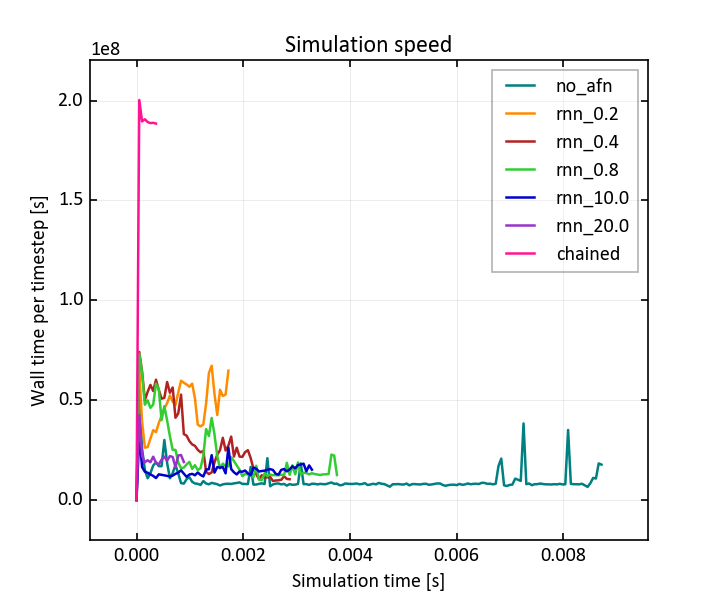

In [226]:
fig, ax = plt.subplots(dpi = 120)

for case in casestore:
    ds = casestore[case].ds
    wtime = ds["wtime"][:-1].values
    tstep = ds["t"].diff("t").values
    
    wtime_per_tstep = wtime/tstep
    time = ds["t"][:-1].values - ds["t"][0].values

    
    ax.plot(time, wtime_per_tstep, label = case)
    
ax.legend()
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Wall time per timestep [s]")
ax.set_title("Simulation speed")

### DDT plot
- Clearly electron, neutral and ion pressure are having extreme spikes here

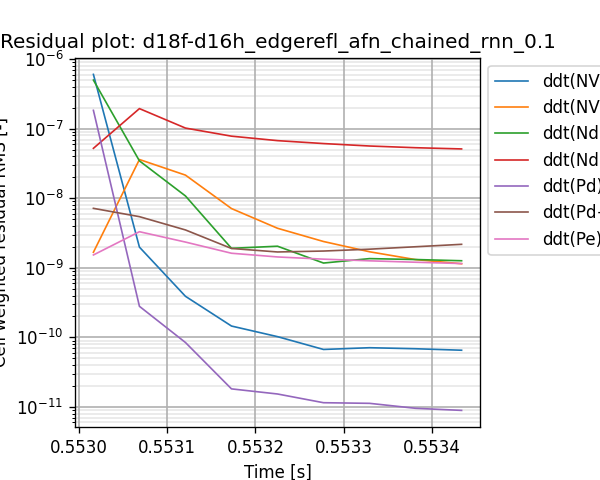

In [142]:
plot_ddt(casestore["chained"])

In [94]:
ds = casestore["rnn_0.4"].ds
ds.coords["t"][30].values

array(0.55400797)

In [131]:
%matplotlib widget
# plt.close("all"); %matplotlib inline

## Source of fluctuations
- Ion and electron pressure are spiking from the mesh seam regions
- The spike starts radially and can then propagate poloidally
- It spreads wide and crashes
- However it is not present in the ultra slow AFN unchained case

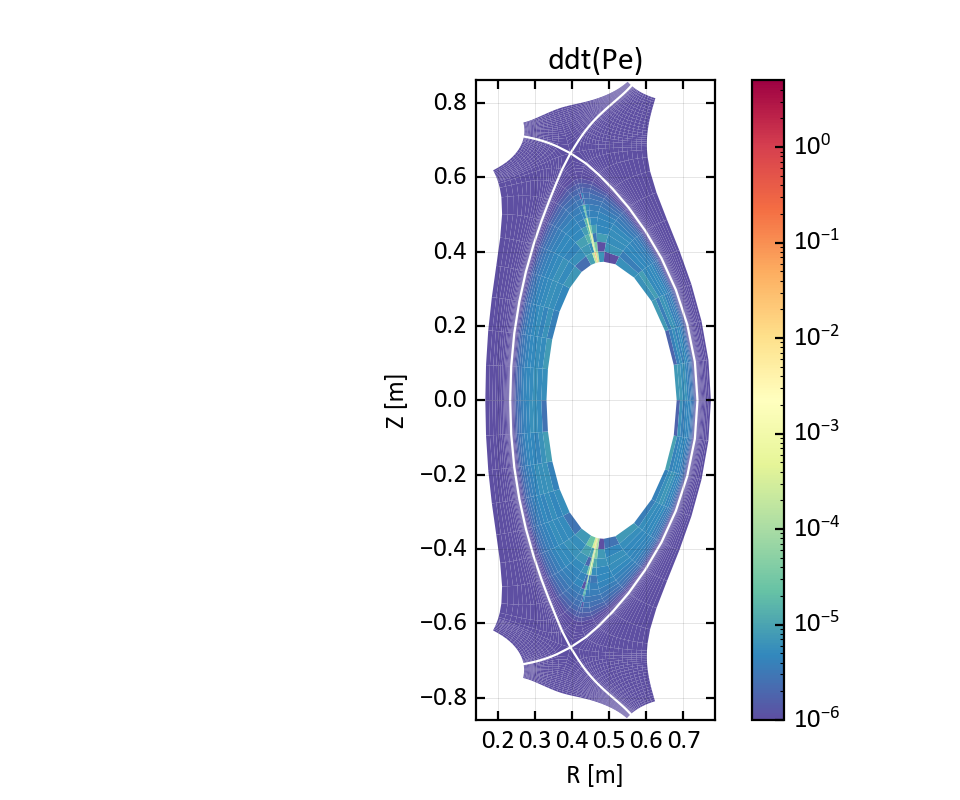

In [213]:
plt.close("all")
fig, ax = plt.subplots(dpi = 160)
# ds = casestore["rnn_0.4"].ds.isel(t=30)
ds = casestore["rnn_0.4"].ds
data = ds["ddt(Pe)"].hermesm.clean_guards()
# data = np.sqrt(np.mean(data**2, axis = (1,2)))
data = np.abs(data).hermesm.clean_guards()
lim = 1e-4
data.hermesm.clean_guards().bout.polygon(
    ax = ax, cmap = "Spectral_r", antialias = True, vmin = 1e-6, vmax = None, logscale = True)
# xbout.plotting.animate.animate_poloidal(
#     data, ax = ax, cmap = "Spectral_r", linewidth = 0.1,vmin = 1e-6, vmax = 1e-4, logscale = True
# )


In [152]:
plt.close("all")
%matplotlib inline

### Quite tricky to pick it out numerically
- Max doesn't work cause apparently that doesn't change
- Mean doesn't work even though we're not volume weighted
- Median does show the flashes
- The flashes coincide with spikes of ddt(Pe), but don't trend with slowdowns

Text(0.5, 1.0, 'History of flashes in core')

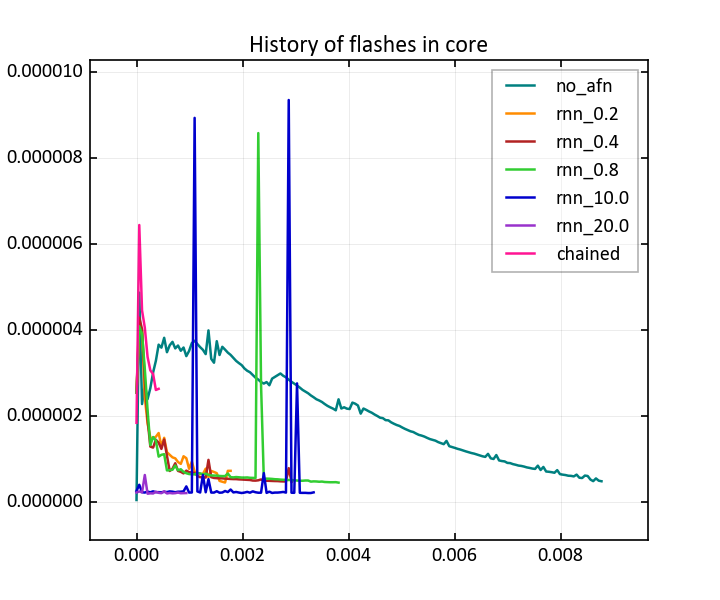

In [218]:
# plot_selection(ds, ds.hermesm.select_region("core"))

fig, ax = plt.subplots()

for case in casestore:
    ds = casestore[case].ds
    core = ds.hermesm.select_region("core")
    data = np.abs(core["ddt(Pe)"]).median(["x", "theta"]) 
    time = ds["t"] - ds["t"][0]
    ax.plot(time, data, label = case)
    # data.plot(ax = ax, label = case)
    
ax.legend()
ax.set_title("History of flashes in core")

## There are also flashes in ddt(Nd)
- Seem in rnn_0.4
- Present at OMP and symmetric about the midplane
- Present at separatrix above upper x-point

In [207]:
%matplotlib widget

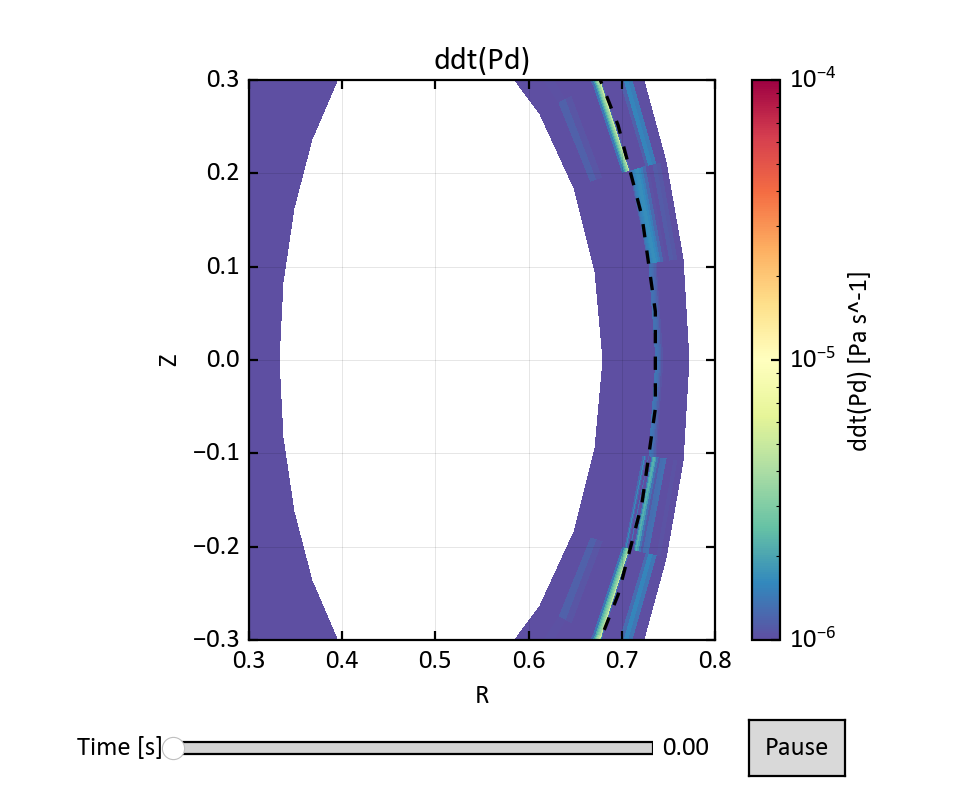

In [211]:
plt.close("all")
fig, ax = plt.subplots(dpi = 160)
# ds = casestore["rnn_0.4"].ds.isel(t=30)
ds = casestore["rnn_10.0"].ds
data = ds["ddt(Nd)"]
# data = np.sqrt(np.mean(data**2, axis = (1,2)))
data = np.abs(data).hermesm.clean_guards()
lim = 1e-4
ax.set_ylim(-0.3, 0.3)
ax.set_xlim(0.3,0.8)
# data.isel(t=-1).hermesm.clean_guards().bout.polygon(
#     ax = ax, cmap = "Spectral_r", antialias = True, vmin = 1e-6, vmax = lim, logscale = True)
xbout.plotting.animate.animate_poloidal(
    data, ax = ax, cmap = "Spectral_r", linewidth = 0.1,vmin = 1e-6, vmax = 1e-4, logscale = True
)




Text(0.5, 1.0, 'History of flashes in core')

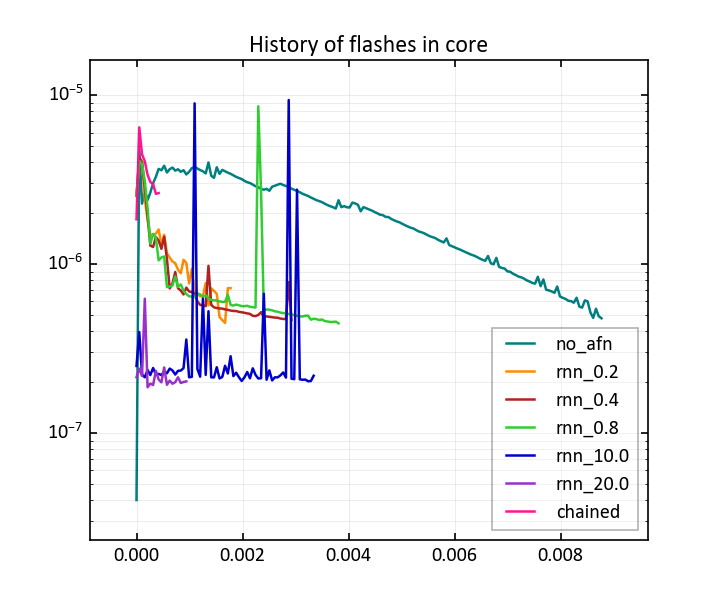

In [224]:
# plot_selection(ds, ds.hermesm.select_region("sol"))

fig, ax = plt.subplots()

for case in casestore:
    ds = casestore[case].ds
    core = ds.hermesm.select_region("core")
    data = np.abs(core["ddt(Pe)"]).median(["x", "theta"]) 
    time = ds["t"] - ds["t"][0]
    ax.plot(time, data, label = case)
    # data.plot(ax = ax, label = case)
    
ax.legend()
ax.set_yscale("log")
ax.set_title("History of flashes in core")

In [ ]:
# Analyse 

In [ ]:
plt.close("all")

In [ ]:
fig, ax = plt.subplots()

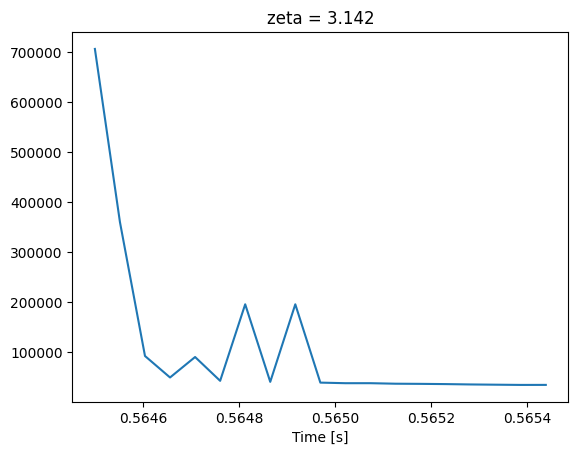

In [84]:
fig, ax = plt.subplots()

data = ds["hf_perp_diff_L_d"] / (ds["dy"] * ds["dz"])
data = data.differentiate("t")
data = np.sqrt(np.mean(data**2, axis = (1,2)))

data.plot()

# Lineplots

In [15]:
hr.keys()

dict_keys(['newafn', 'rnn_0.2', 'rnn_0.4', 'rnn_0.8', 'rnn_1.6'])

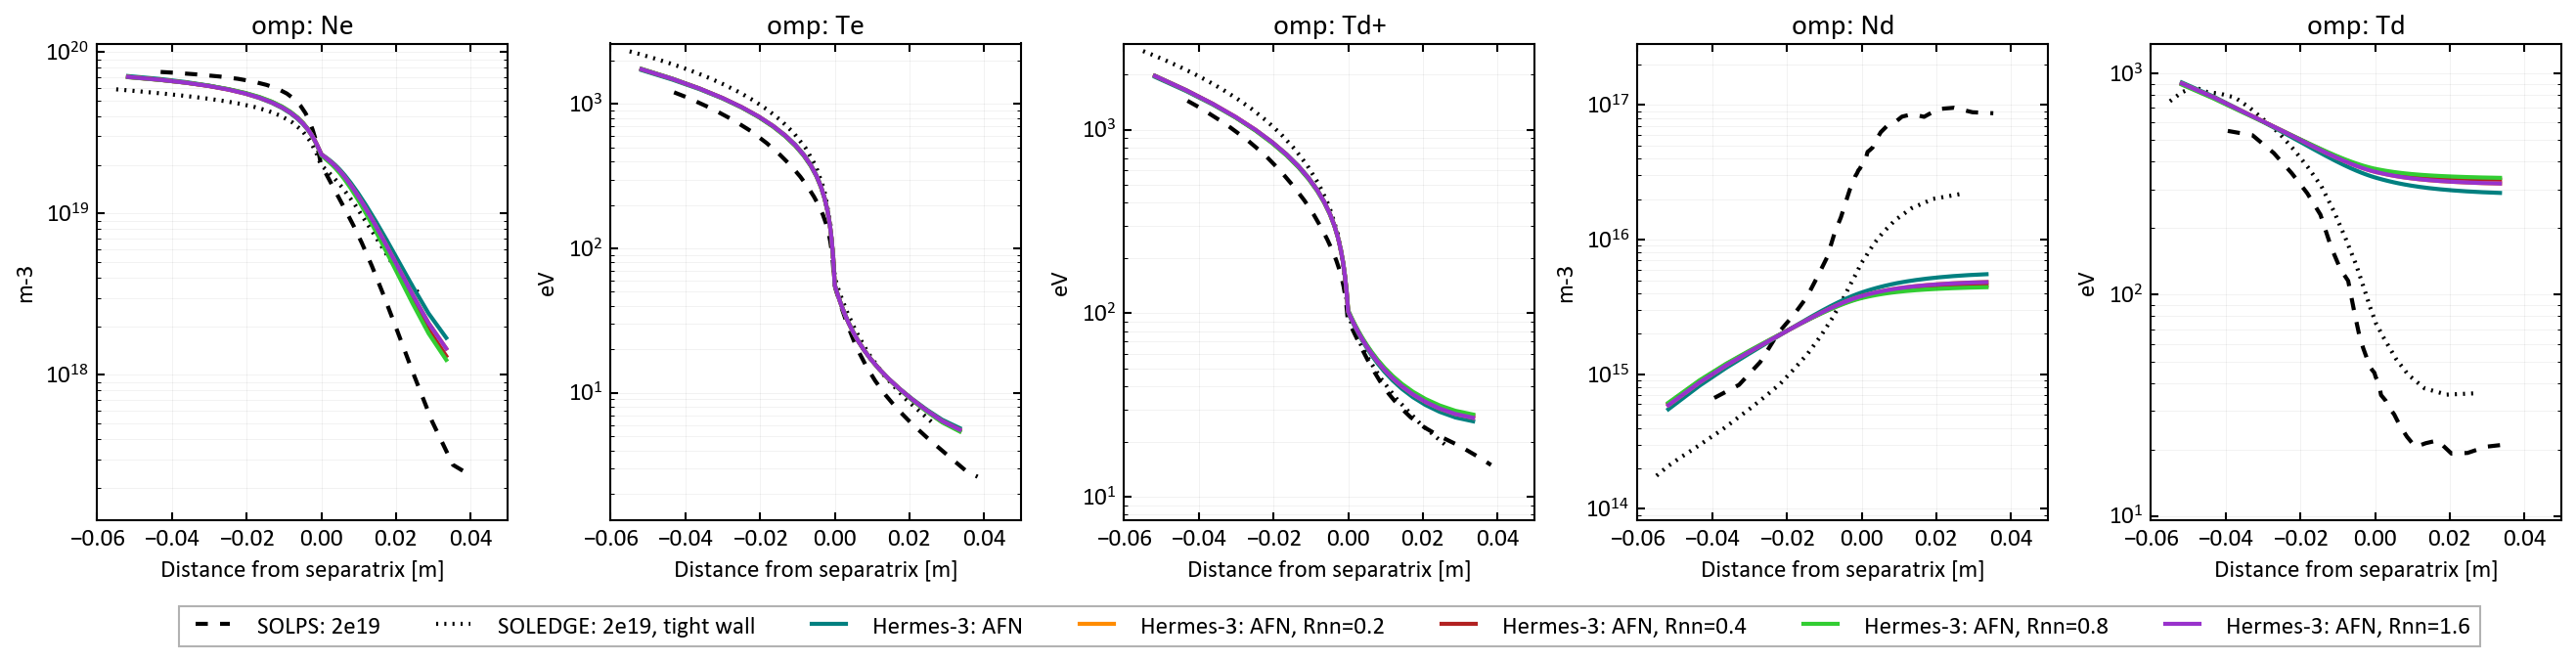

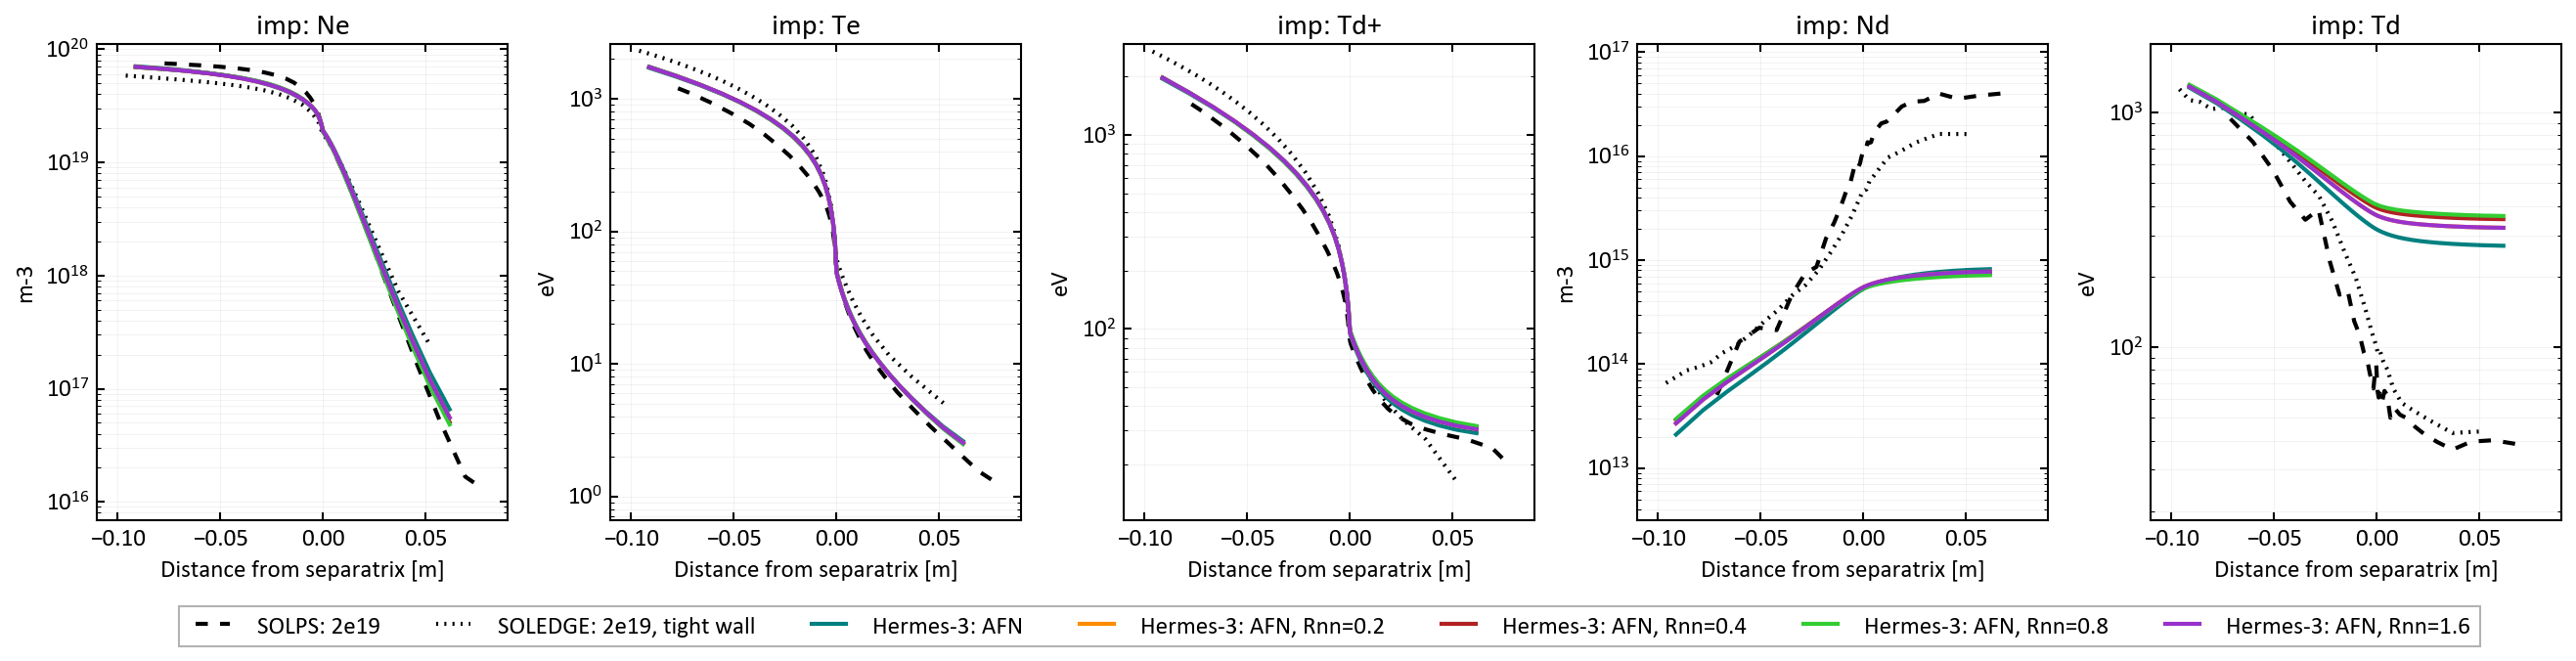

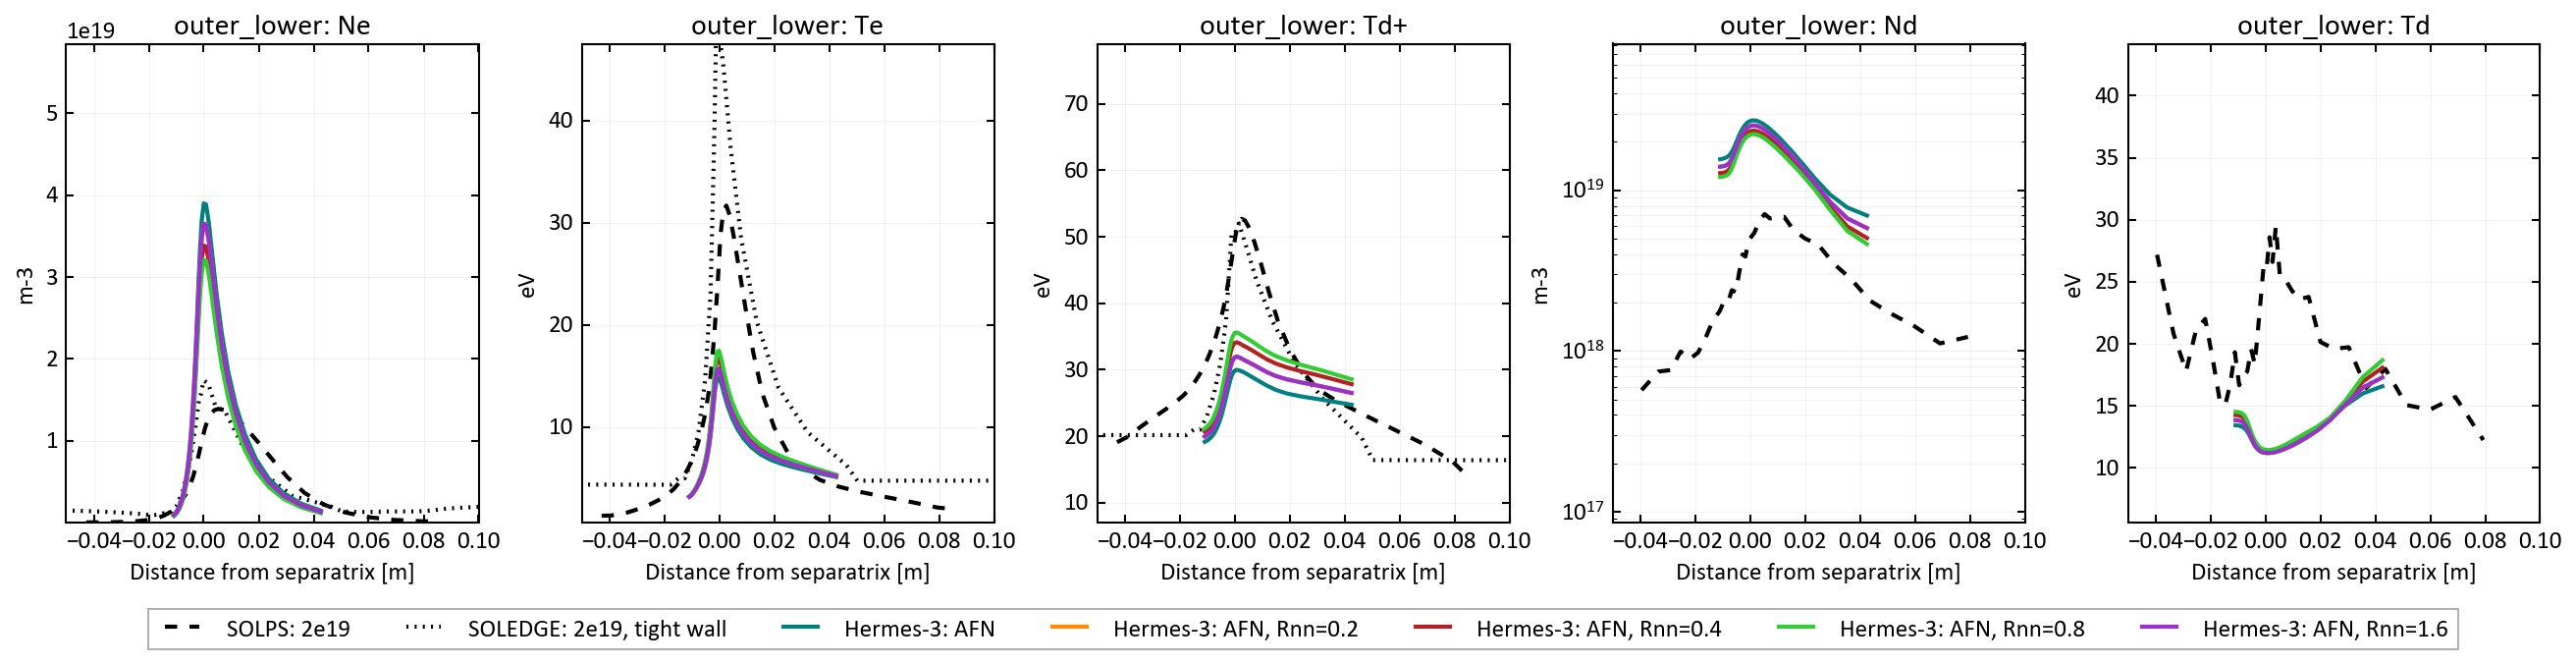

In [16]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    # "SOLPS: 1e19" : dict(data=sp["no_visc"], color="#3288bd"),
    "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="black"),
    # "SOLPS: 3e19" : dict(data=sp["nsep_3e19"], color="#fc8d59"),
    
    "SOLEDGE: 2e19, tight wall" : dict(data=sl["tightwall_2e19"], color = "black"),

    
    "Hermes-3: AFN": dict(data=hr["newafn"], color="teal"),
    "Hermes-3: AFN, Rnn=0.2": dict(data=hr["rnn_0.2"], color="darkorange"),
    "Hermes-3: AFN, Rnn=0.4": dict(data=hr["rnn_0.4"], color="firebrick"),
    "Hermes-3: AFN, Rnn=0.8": dict(data=hr["rnn_0.8"], color="limegreen"),
    "Hermes-3: AFN, Rnn=1.6": dict(data=hr["rnn_1.6"], color="darkorchid"),
    # "Hermes-3: Edge recycling": dict(data=hr["2e19_edgerec"], color="cyan"),
    

    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

#  Neutral energy transport

In [37]:
for case in casestore:
    casestore[case].ds = calculate_radial_fluxes(casestore[case].ds)
    casestore[case].ds = reverse_pfr_fluxes(casestore[case].ds)

### Integrals

In [ ]:
for case in ["lim_1.0", "lim_0.2", "isolim"]:
    print(case)
    plot_perp_heat_fluxes(casestore[case].ds.isel(t=-1), loc = "integral", ylim=(-0.25, 1.0))

### OMP

In [ ]:
for case in ["lim_1.0", "lim_0.2", "isolim"]:
    print(case)
    plot_perp_heat_fluxes(casestore[case].ds.isel(t=-1), loc = "omp", ylim=(-20e3, 110e3))

## Looking at the fluxes across domain

In [42]:
casestore.keys()

dict_keys(['rnn_0.2', 'rnn_0.4', 'rnn_0.8', 'rnn_10.0', 'rnn_20.0'])

(-0.86, 0.1)

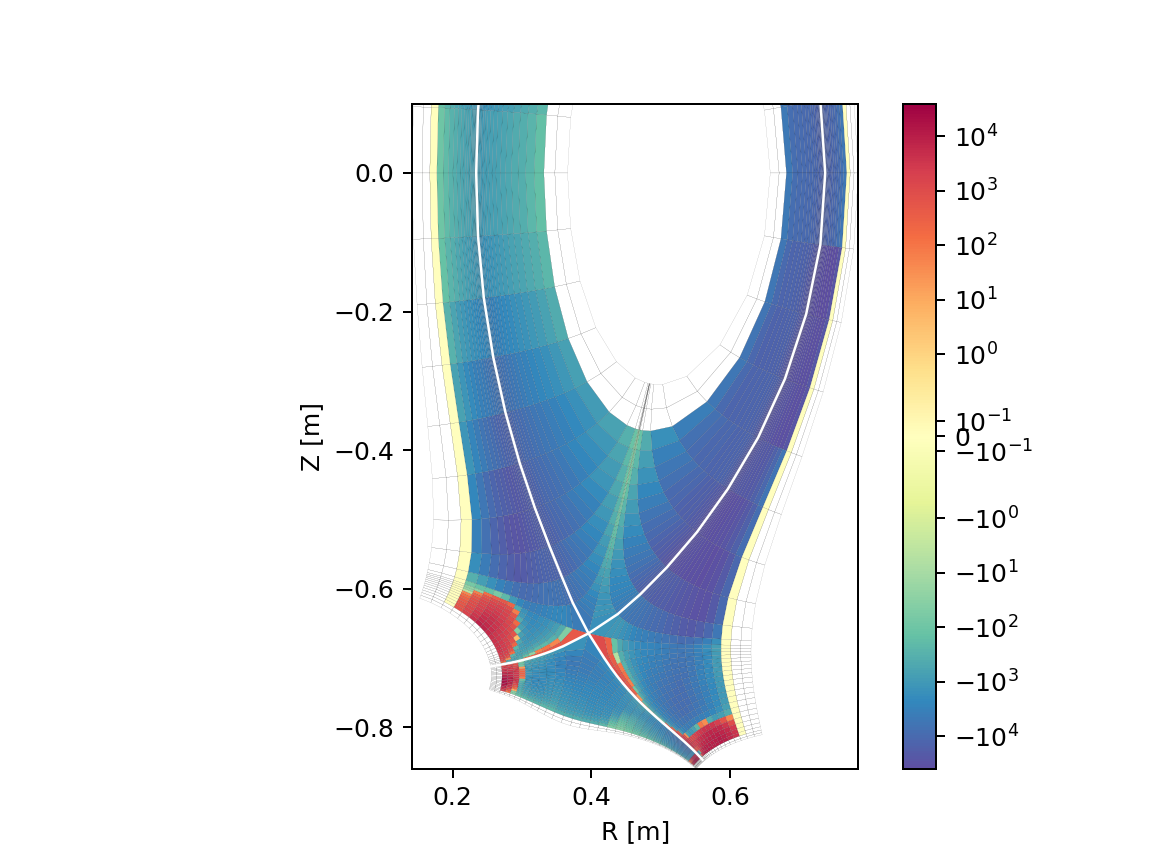

In [59]:
%matplotlib widget
ds = casestore["rnn_10.0"].ds
fig, ax = plt.subplots(dpi = 180)
# ds["hf_perp_tot_R_d"].bout.polygon(cmap="Spectral_r", ax = ax)
(ds["hf_perp_conv_R_d"] / ds["dy"] / ds["dz"]).isel(t=-1).hermesm.clean_guards().bout.polygon(
    cmap="Spectral_r", ax = ax, vmin = -40000, vmax = 40000, logscale = True, antialias = True, linewidth = 0.03)

ax.set_ylim(-0.86, 0.1)

In [29]:
fluxes_to_correct

['hf_perp_diff_L_d+',
 'hf_perp_diff_R_d+',
 'hf_perp_conv_L_d+',
 'hf_perp_conv_R_d+',
 'hf_perp_tot_L_d+',
 'hf_perp_tot_R_d+',
 'hf_perp_diff_L_e',
 'hf_perp_diff_R_e',
 'hf_perp_conv_L_e',
 'hf_perp_conv_R_e',
 'hf_perp_tot_L_e',
 'hf_perp_tot_R_e',
 'hf_perp_conv_L_d',
 'hf_perp_conv_R_d',
 'hf_perp_diff_L_d',
 'hf_perp_diff_R_d',
 'hf_perp_tot_L_d',
 'hf_perp_tot_R_d',
 'pf_perp_diff_L_d+',
 'pf_perp_diff_R_d+',
 'pf_perp_diff_L_e',
 'pf_perp_diff_R_e',
 'pf_perp_diff_L_d',
 'pf_perp_diff_R_d',
 'EnergyFlow_d+_xlow',
 'EnergyFlow_d+_ylow',
 'EnergyFlow_e_xlow',
 'EnergyFlow_e_ylow',
 'MomentumFlow_d+_xlow',
 'ParticleFlow_d+_xlow',
 'ParticleFlow_d+_ylow']

In [26]:
ds.data_vars

Data variables:
    Bxy                     (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    Dnnd                    (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    Ed+_iz                  (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    Ed+_rec                 (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    Ed_pfr_recycle          (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    Ed_sol_recycle          (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    Ed_target_recycle       (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    Edd+_cx                 (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    EnergyFlow_d+_xlow      (t, x, theta) float64 dask.array<chunksize=(35, 40, 108), meta=np.ndarray>
    EnergyFlow_d+_ylow      (t, x, theta) float64 dask.array<chu

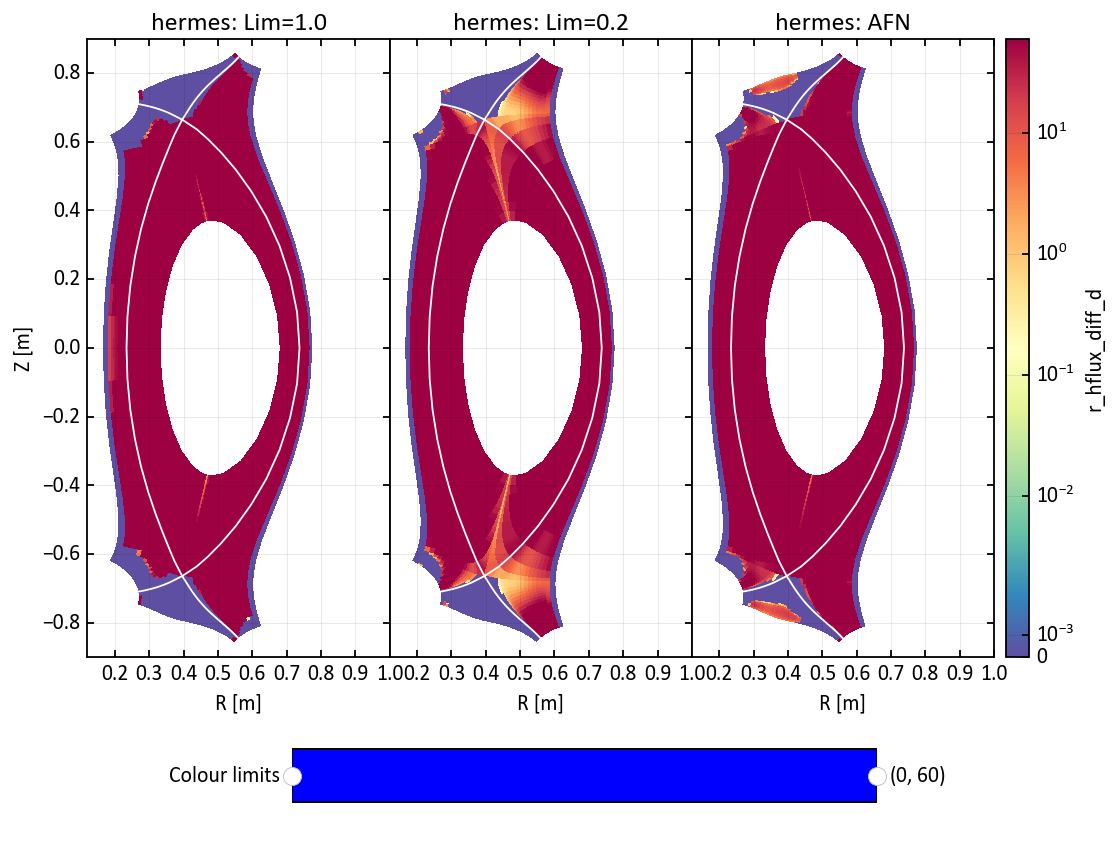

In [33]:
v = viewer_2d(
    "r_hflux_diff_d",
    [
        # {"name" : "Lim=1.0", "code" : "hermes", "ds" : casestore['lim_1.0'].ds.isel(t=-1)},
        # {"name" : "Lim=0.2", "code" : "hermes", "ds" : casestore['lim_0.2'].ds.isel(t=-1)},
        {"name" : "AFN", "code" : "hermes", "ds" : casestore['isolim'].ds.isel(t=-1)},
    ],
    logscale = True,
    vmin = 0,
    vmax = 60,
    # vmin = 1e17,
    # vmax = 1e19,
    dpi = 130,
    ylim = (-0.9,0.9),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

In [28]:
casestore.keys()

dict_keys(['nolim', 'lim_0.2', 'lim_1.0', 'isolim'])

# Total energy flux

Text(0.5, 1.0, '')

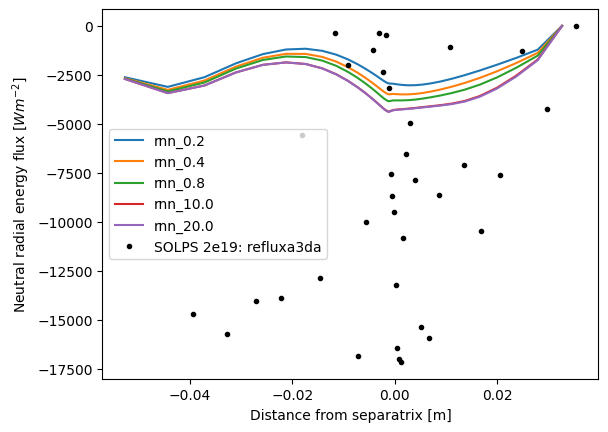

In [18]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn", "halfcond"]

for i, case in enumerate(casestore):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = case)


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS 2e19: refluxa3da", color = "black", lw=0, marker = "o", ms = 3,)
ax.set_ylabel("Neutral radial energy flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")

# PARTICLE FLUX

Text(0.5, 1.0, '')

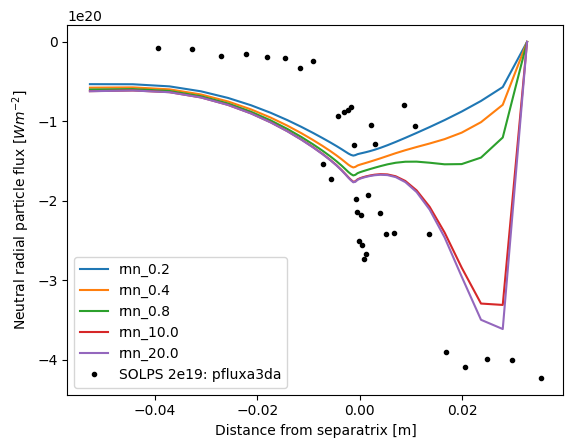

In [20]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(casestore):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = case)


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS 2e19: pfluxa3da", color = "black", lw=0, marker = "o", ms = 3,)
ax.set_ylabel("Neutral radial particle flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")

# Convective energy flux

Text(0.5, 1.0, '')

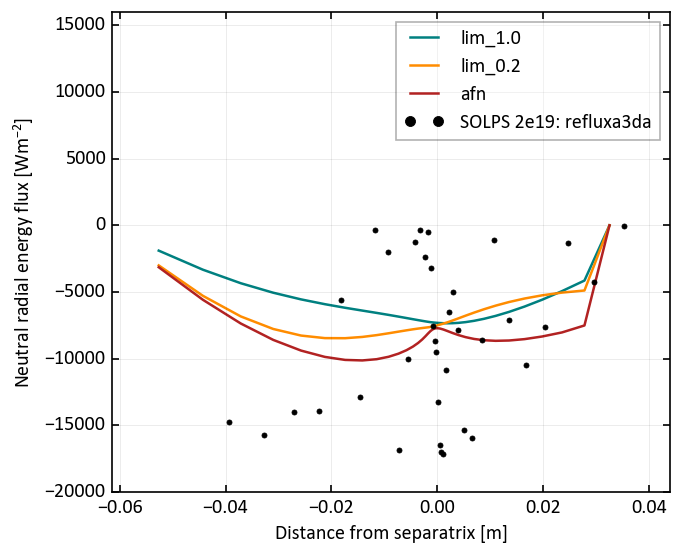

In [52]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(["lim_1.0", "lim_0.2", "isolim"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_conv_R_d"] / (omp["dy"]*omp["dz"]), label = labels[i], ls = "-")


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS 2e19: refluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial energy flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()
ax.set_ylim(-2e4, 16e3)
ax.set_title("")

Text(0.5, 1.0, 'AFN Limiter factors at OMP')

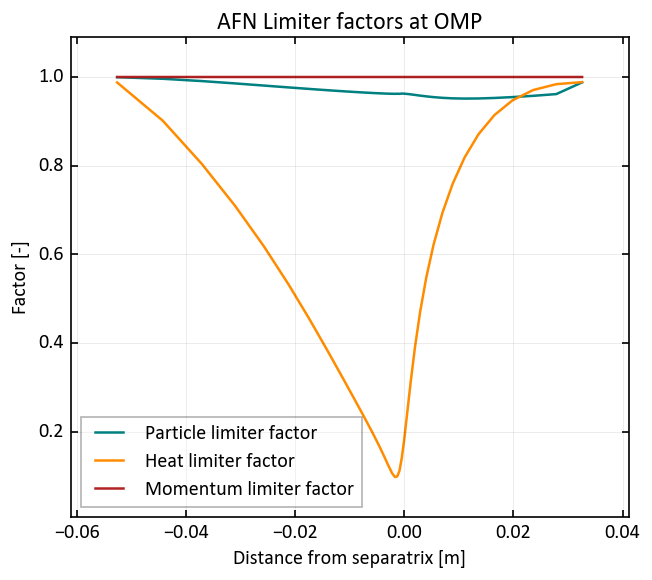

In [57]:
fig, ax = plt.subplots()

ds = casestore["isolim"].ds.isel(t=-1)
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])

ax.plot(dist, omp["particle_flux_factor_d"], label = "Particle limiter factor")
ax.plot(dist, omp["heat_flux_factor_d"], label = "Heat limiter factor")
ax.plot(dist, omp["momentum_flux_factor_d"], label = "Momentum limiter factor")

ax.legend()
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Factor [-]")
ax.set_title("AFN Limiter factors at OMP")


Text(0.5, 1.0, '')

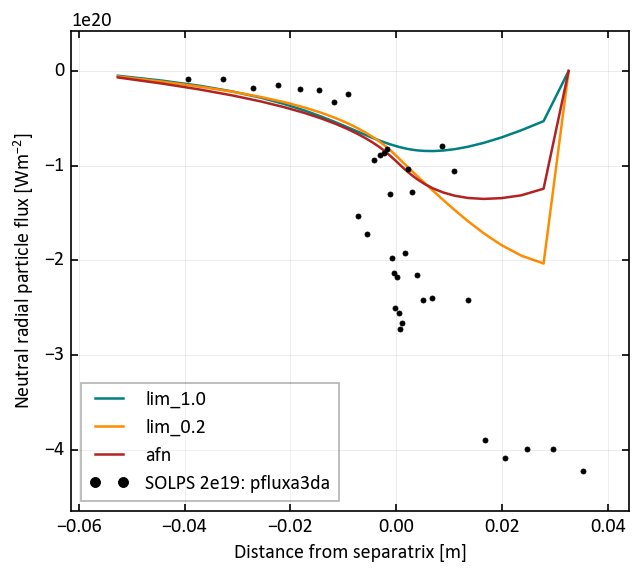

In [40]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(["lim_1.0", "lim_0.2", "isolim"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = labels[i])


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS 2e19: pfluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial particle flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")